## 05 Evaluation & Conceptual Understanding

* In this notebook, first we will give an overview of the performance of all the models, and proceed to interpret the production model selected.
* Next we are going to trace along the production model and interprete its output, by extracting the top occurance features and interpreting the output results of the classficiation model (words with highest occurance for both classes, and the relative ratio of probability of occurance between the two classes).

In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords 
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import f1_score,confusion_matrix, ConfusionMatrixDisplay,plot_roc_curve 
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [47]:
# summary of metrics 

|   |               Model                    | Training F1 | Testing F1 | Training Accuracy | Testing Accuracy |   Specificity|  NPV    |  AUC  |
|:-:|:--------------------------------------:|:-----------:|:----------:|:-----------------:|:----------------:|:------------:|:-------:|:-----:|
| 0 | Baseline (null model)                  |     0.947   |    0.947   |       0.899       |      0.899       |      0       |   -     | 0.50  |
| 1 | TF-IDF + Multinomial NB                |     0.952   |    0.950   |       0.910       |      0.905       |      0.089   | 0.809   | 0.85  |
| 2 | TF-IDF + Random Forest                 |     0.999   |    0.954   |       0.999       |      0.914       |      0.226   | 0.746   | 0.92  |
| 3 | TF-IDF + LinearSVC                     |     0.998   |    0.928   |       0.999       |      0.961       |      0.485   | 0.713   | 0.93  |
| 4 | TF-IDF + VotingClassifier              |     0.983   |    0.953   |       0.970       |      0.915       |      0.400   | 0.627   |  -    |
| 5 | TF-IDF + Multinomial NB (oversampling) |     1.000   |    0.958   |       1.000       |      0.921       |      0.217   | 1.000   | 0.99  |
| 6 | TF-IDF + Random Forest (oversampling)  |     1.000   |    0.959   |       1.000       |      0.921       |      0.243   | 1.000   | 0.99  |

* Baseline model (predicting all results as the majority class) will give a 89.8% accuracy, but the specificity metric is 0 as the model does not correctly predict any data as the r/stocks class. 

* Based on the F1 scores, all models are overfit for up to 4-7%. 

* As we have explained in Part 04, the most two important metrics are Negative Predictive Value (NPV) and Specificity. These two collectively represent the model's ability of correctly identifying class r/stocks posts. And NPV is prioritized if we need to trade off between the two. F1 score on the testing dataset is also a metric we looked at. 

* As shown in the table above, performance of model 0-4 are characteristic of an imbalanced dataset. Due to the high imbalance (0.9/0.1 ratio), even the null baseline model of predicting everything as the majority class has high F1 score and accuracy as the majority class correct predition rate has overwhelmed the false prediction rates on the minority class. This effect has dominated the metrics of accuracy and F1 score, hence for accuracy and F1 score, Model 1-4 do not give much room of improvement from the baseline score. However, the metric Specificity and NPV have increased substantially. 

* Model 2-4 have all incorpurated class_weight='balanced' in their argument inputs to give more penalty to the false preditions on the minority class. Among Model 1-4 on the original imbalanced dataset, Model 3 LinearSVR model outperforms the other three in having the highest Specificity and NPV scores. In Model 5-6, once the training dataset has been treated using oversampling method to achieve a balanced input, the performance of the Multinomial NB and Random Forest have greatly improved, especially for their NPV scores.

* As NPV is prioritized over Specificity in our casestudy, the Specificity and NPV scores of Model 5 and 6 are preferable than Model 3. For the benefit of interpretability, we will choose the Model 5 (multinomial NB with oversampling treatment) as the production model. 

#### Reproduce the production model and interprete the intermediate output

In [4]:
%store -r gs_tvec_oversample
%store -r X2_train
%store -r y2_train
%store -r customized_stop_words

In [9]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        regex_num_ponctuation = '(\d+)|([^\w\s])'
        regex_little_words = r'(\b\w{2,3}\b)'
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)
                if not re.search(regex_num_ponctuation, t) and not re.search(regex_little_words, t)]

In [11]:
# specify for Tf-idf vectorizer to use lemmatized vocabulary for counting.  
# the optimal set of parametersfrom gridsearch in Part_04 are directly specified in the model arguments below.
tvec = TfidfVectorizer(tokenizer=LemmaTokenizer(),stop_words=customized_stop_words,max_features= 2000,
 ngram_range=(1, 1))

In [16]:
X2_train_df = pd.DataFrame(tvec.fit_transform(X2_train).toarray(), 
                          columns=tvec.get_feature_names_out())

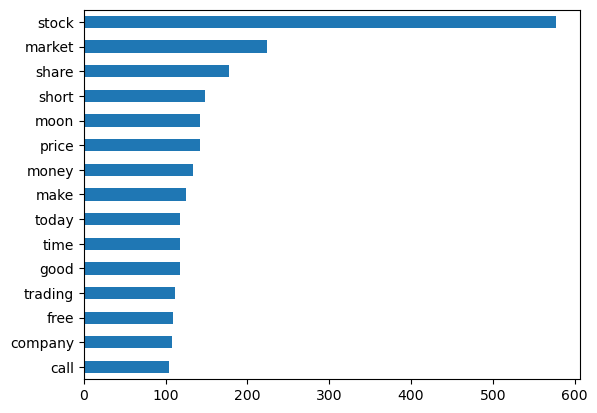

In [17]:
X2_train_df.sum().sort_values(ascending=False).head(15).plot(kind='barh').invert_yaxis();

In [21]:
nb= MultinomialNB()
nb.fit(X2_train_df,y2_train)

MultinomialNB()

Now we are going to extract the features with the highest probability of occurance for both classes. 

In [23]:
neg_class_prob_sorted=nb.feature_log_prob_[0,:].argsort()[::-1]
pos_class_prob_sorted=nb.feature_log_prob_[1,:].argsort()[::-1]
print('r/Stock top words:',np.take(tvec.get_feature_names(), neg_class_prob_sorted[:15]))
print('r/Wallstreetbet top words:',np.take(tvec.get_feature_names(), pos_class_prob_sorted[:15]))

r/Stock top words: ['stock' 'market' 'share' 'free' 'price' 'analysis' 'trading' 'fund'
 'moon' 'today' 'best' 'make' 'next' 'good' 'short']
r/Wallstreetbet top words: ['stock' 'short' 'yolo' 'market' 'money' 'moon' 'share' 'going' 'week'
 'time' 'call' 'year' 'make' 'company' 'good']


* It can be seen that quite a few of the top occurance words are shared by both groups, like 'stock', 'market' and so on. But there do exist words that occurs highest only in one particular class, for example, 'trading', 'fund', 'analysis' only top in the stock class, while 'yolo' only top in wallstreetbet class.

We now put the logrithmic probability of occurance of each of the top 2000 words in both classes into a dataframe. To gain an idea of how the likelihood of occurance compares between the two classes for each word, we will add another column 'ratio_0_to_1' which is the ratio between the probability of occurance for two classes in the dataframe.
* Those words with ratio value higher than 1 have a higher probability of occurance in class 0 (stock) relative to that of class 1 (wallstreetbet), and existence of such words in a document will contribute to its being predicted as class 0 (stock). 
* Likewise, existence of those words with a ratio smaller than 1 in a particular document will contribute to the document being predicted to class 1 (wallstreetbet).

In [34]:
output=pd.DataFrame()
output['feature_name']=tvec.get_feature_names_out()
output['class_0_log_prob']=nb.feature_log_prob_[0]
output['class_1_log_prob']=nb.feature_log_prob_[1]
output['ratio_0_to_1']=[(math.exp(output['class_0_log_prob'][i]-output['class_1_log_prob'][i])) for i in range(output.shape[0])]

In [44]:
output.sort_values(by='class_0_log_prob',ascending=False).head(10)

,feature_name,class_0_log_prob,class_1_log_prob,ratio_0_to_1
1693,stock,-3.381424,-4.948459,4.792418
1071,market,-4.596532,-5.203417,1.834707
1578,share,-4.911565,-5.322494,1.508218
729,free,-5.028326,-6.601336,4.821142
1339,price,-5.090156,-5.590073,1.648584
70,analysis,-5.161950,-7.338273,8.813838
1819,trading,-5.224264,-5.992720,2.156436
740,fund,-5.376387,-6.423939,2.850664
1131,moon,-5.401462,-5.268446,0.875451
1804,today,-5.420398,-5.605614,1.203479


In [43]:
output.sort_values(by='class_1_log_prob',ascending=False).head(10)

,feature_name,class_0_log_prob,class_1_log_prob,ratio_0_to_1
1693,stock,-3.381424,-4.948459,4.792418
1591,short,-5.500877,-5.136656,0.694738
1988,yolo,-6.928502,-5.197909,0.177179
1071,market,-4.596532,-5.203417,1.834707
1126,money,-5.584302,-5.258927,0.722257
1131,moon,-5.401462,-5.268446,0.875451
1578,share,-4.911565,-5.322494,1.508218
771,going,-6.098365,-5.363239,0.479445
1932,week,-6.318719,-5.377924,0.390317
1798,time,-5.682948,-5.396005,0.750555


In [62]:
visual=pd.concat([output.sort_values(by='class_0_log_prob',ascending=False).head(15),output.sort_values(by='class_1_log_prob',ascending=False).head(15)])
visual.drop_duplicates(inplace=True)
visual.shape

(23, 4)

From the number of dropped duplicates, we know that there are 7 words that are among the top 15 features for both classes. 

Next we will create a new dataframe to represent the true probablity of occurance for the top words.

In [79]:
visual_to_scale['class_0_prob']= [math.exp(visual['class_0_log_prob'][i]) for i in range(visual.shape[0])]
visual_to_scale['class_1_prob']= [math.exp(visual['class_1_log_prob'][i]) for i in range(visual.shape[0])]
visual_to_scale.drop(columns=['class_0_log_prob','class_1_log_prob'],inplace=True)

In [169]:
visual_to_scale.sort_values(by='ratio_0_to_1',ascending=False,inplace=True)
visual_to_scale.reset_index(drop=True,inplace=True)
visual_to_scale

,feature_name,ratio_0_to_1,class_0_prob,class_1_prob
0,analysis,8.813838,0.005731,0.000650
1,free,4.821142,0.006550,0.001359
2,stock,4.792418,0.033999,0.007094
3,fund,2.850664,0.004625,0.001622
4,trading,2.156436,0.005384,0.002497
5,best,2.001284,0.004336,0.002167
6,market,1.834707,0.010087,0.005498
7,price,1.648584,0.006157,0.003735
8,share,1.508218,0.007361,0.004881
9,next,1.443003,0.004280,0.002966


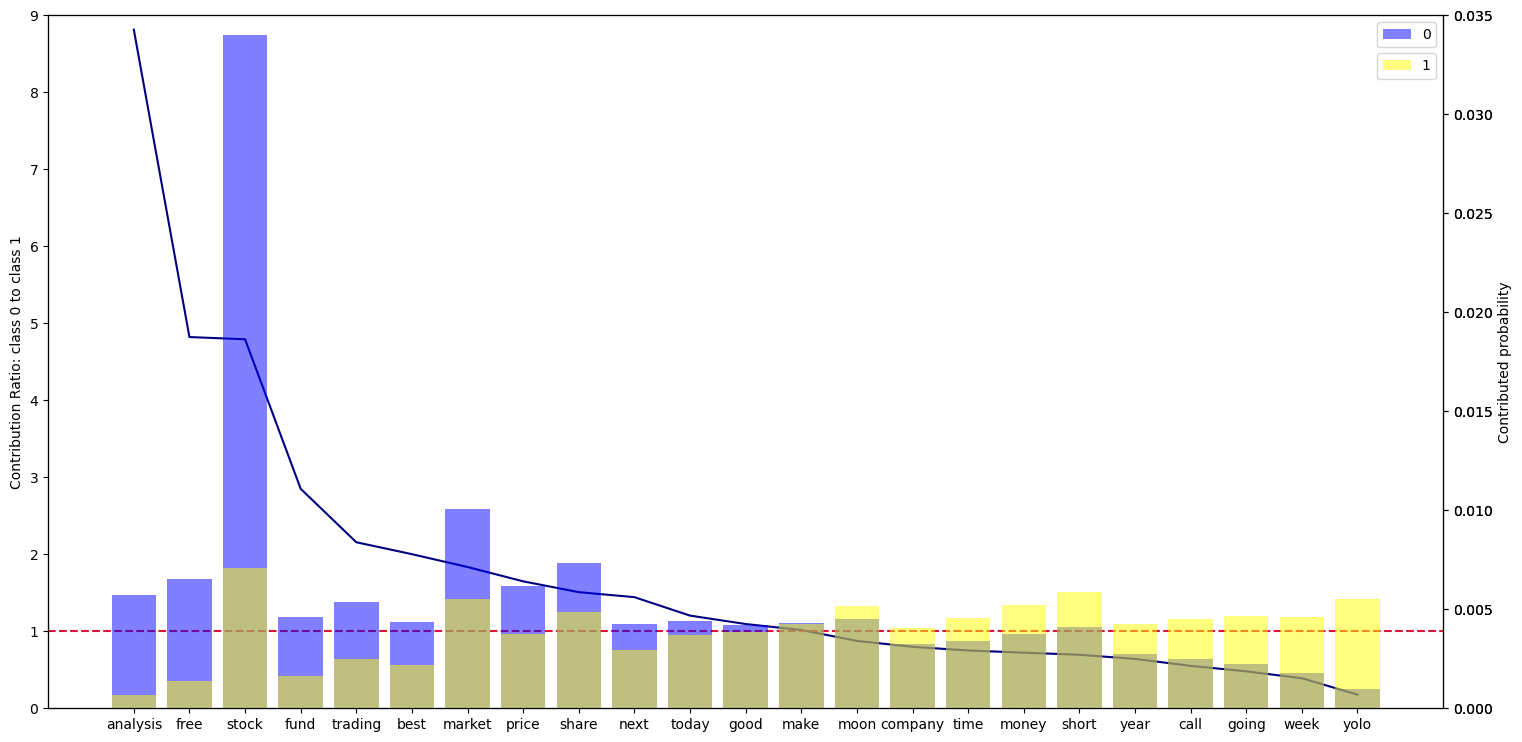

In [172]:
fig,ax=plt.subplots(figsize=(18,9))
ax.plot(visual_to_scale.sort_values(by='ratio_0_to_1',ascending=False)['feature_name'],visual_to_scale['ratio_0_to_1'],color='navy')
ax.axhline(y=1,linestyle = 'dashed',color='crimson')
ax.set_ylim([0,9])
ax.set_ylabel('Contribution Ratio: class 0 to class 1')

ax2=ax.twinx()
ax2.bar(visual_to_scale.sort_values(by='ratio_0_to_1',ascending=False)['feature_name'],visual_to_scale['class_0_prob'],color='blue',alpha=0.5)
ax2.set_ylim([0,0.035])
ax2.legend('0',loc='upper right', bbox_to_anchor=(1, 1))

ax3=ax.twinx()
ax3.bar(visual_to_scale.sort_values(by='ratio_0_to_1',ascending=False)['feature_name'],visual_to_scale['class_1_prob'],color='yellow',alpha=0.5)
ax3.set_ylim([0,0.035])
ax3.legend('1',loc='upper right', bbox_to_anchor=(1, 0.955))
ax3.set_ylabel('Contributed probability')

plt.show()

#### Interpretations:

1. On the X-axis are the top 15 features from both r/stocks and r/wallstreetbets. As there are 7 overlaping features, in total there are 23 features in the plot. 

2. The blue bars represents each word's probability of occurance in a Class 0 (r/stocks) post; whereas the yellow bars represents each word's probability of occurance in a Class 1 (r/wallstreetbets) post. The y values of the bar plots are on the right side. Based on the Naive Bayes assumption, we can effectively interprete the blue bars as the probabilitistic contribution of the presence of a particular word in a text document to the probabilitity of that document belonging to Class 0 (stock); and likewise, the yellow bars represent the probabilitstic contribution of the presence of a particular word in a text document to the probability of that document belonging to Class 1 (wallstreetbet).

3. The blue line represents the ratio between the two probabilities of occurance in Class 0 (r/stocks) post versus in Class 1 (r/wallstreetbets) post for a particular word.  The y values of the line plot is on the left side. The blue line gives a good indication of a word's relative contribution to classifying documents with the word to r/stocks versus to r/wallstreetbets. 

4. The words on the X-axis are sorted in decending order in the ratio of the two probabilities as defined in (3). Hence the more towards the left, presence of the words are more biased to contributing to classifying documents with them as r/stocks, whereas the more towards the right, presence of these words are more biased to contributing to classifying documents with them as r/wallstreetbets.

5. The dashed horizontal red line denotes y=1, and its intersection with the blue line defined in (3) have seperated the words on the X-axis to two groups: presence of those of the left side have a higher contribution to classifying to r/stocks rather than r/wallstreetbets subreddit; presence of those words to the right hand side have a higher contribution classifying into r/wallstreetbets. 

6. If we want to identify the top words that distinguish a document as a 'r/stocks' post, then we should take from the left hand side, the most prominent five being 'analysis', 'free', 'stock', 'fund' and 'trading'. 

7. Likewise, if we want to identify the top words that distinguish a document as a 'r/wallstreetbets' post, we should take from the right hand side, the most prominent five being 'yolo', 'week', 'going', 'call' and 'year'. 

8. It can be seen from the bar charts that there are some common top occurance words that have similar probablistic contribution to both classes, such as 'good', 'make' and 'moon'. If there is future analysis on top of this work, these words can be added to the stop_word list, as they do not help much to distinguish between the two classes.